# **AI 보안 과제2**

RNN 성능 개선

학번 : 2019253084 이름 : 전유성
- 제공된 모델 또는 코드를 수정해 IMDB 데이터셋에서 테스트 정확도를 높이는 것을 목표로 함
- 모델 구조 수정 및 다른 학습 기법을 "자유롭게" 적용

#1. 필요한 라이브러리 설치 및 라이브러리 사용.

In [25]:
!pip3 install pandas matplotlib scikit-learn transformers

In [26]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Now using {device}.")

from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/ai보안 데이터셋/IMDB.csv'


Now using cuda.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. CSV 파일을 읽고 텍스트 전처리

- CSV파일을 읽어와서 텍스트 전처리를 합니다.
- 텍스트 전처리할 때에는 HTML 태그 제거: r'<[^>]+>' 정규식을 사용해 HTML 태그를 모두 제거, 알파벳 외의 모든 문자를 공백으로 변환,
소문자로 변환하여 일관성 유지, 단어를 공백 기준으로 나누고, 다시 하나의 문자열로 결합합니다.

In [28]:
df = pd.read_csv(file_path)
def text_cleaning(text):
    text = re.sub(r'<[^>]+>', '', text) # HTML 태그 제거
    text = re.sub(r'[^a-zA-Z]', ' ', text) # 알파벳 이외의 문자 제거
    text = text.lower()  # 모든 텍스트를 소문자로 변환
    text = text.split()  # 공백 기준으로 단어 분리
    return ' '.join(text) # 단어들을 다시 공백으로 연결하여 반환

df['review'] = df['review'].apply(text_cleaning) # 리뷰 데이터 정제 적용

label_encoder = LabelEncoder() # 레이블 인코딩, 긍정은 1 부정은 0로 변환
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') # BERT 토크나이저 로드
MAX_LEN = 200 # 리뷰 길이 설정

#  토큰화 및 패딩 함수 정의
def tokenize_and_pad(text, tokenizer, max_length):
    return tokenizer(text, padding='max_length', truncation=True, max_length=max_length, return_tensors="pt")['input_ids']

# 리뷰 데이터에 토큰화 및 패딩 적용
df['input_ids'] = df['review'].apply(lambda x: tokenize_and_pad(x, tokenizer, MAX_LEN).squeeze(0).tolist())

# 데이터셋 분할 8 대 2 비율
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# 3.IMDB 데이터셋의 PyTorch Dataset 및 DataLoader 정의

- DataFrame에서 데이터를 PyTorch가 처리할 수 있는 형태로 변환
- 데이터를 모델 학습과 평가에 더 효율적으로 공급하기 위해서 사용

In [29]:
class IMDBDataset(Dataset):
    def __init__(self, dataframe):
        self.input_ids = dataframe['input_ids'].tolist()  # input_ids 데이터를 리스트로 저장.
        self.labels = dataframe['sentiment'].tolist()  # 레이블 데이터를 리스트로 저장.

    def __len__(self):
        return len(self.labels)  # 데이터셋의 전체 길이(샘플 수)를 반환.

    def __getitem__(self, idx):
        input_ids = torch.tensor(self.input_ids[idx], dtype=torch.long)  # 해당 인덱스의 input_ids를 텐서로 변환.
        label = torch.tensor(self.labels[idx], dtype=torch.float)  # 해당 인덱스의 레이블을 텐서로 변환.
        return input_ids, label  # input_ids와 레이블을 반환.

train_dataset = IMDBDataset(train_df)  # 학습용 데이터셋 객체를 생성
test_dataset = IMDBDataset(test_df)  # 테스트용 데이터셋 객체를 생성

# 훈련 및 테스트를 위한 데이터를 로더
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)



# 4. 모델링 설명
BERT + GRU 결합한 모델

- GRU는 RNN 기반의 모델로 순차적 의존성을 학습 그리고 기존의 RNN 모델의 기울기 소실 문제를 해결하기 위한 게이트 매커니즘을 도입한 모델

- BERT는 트랜스포머 기반 모델이기에 RNN모델이 아니지만 병럴 처리가 가능하며 순차적 의존성을 따르지 않음 하지만 BERT 출력을 하여 GRU에 시퀀스의 시간적 흐름을 전달하여 학습함.

- RNN 모델인 이유 : BERT쪽은 텍스트 임베딩을 생성하는 역할만 하고, 순환적 의존성 학습은 GRU에서 수행하고 양방향 GRU이기 때문에 텍스트의 앞뒤 맥락을 모두 학습하여 시퀸스 모델링을 강화하여 RNN모델 계열임.

In [30]:
class BertGRUModel(nn.Module):  # nn.Module을 상속하여 모델을 정의.
    def __init__(self, bert_model, hidden_dim, output_dim, dropout):
        super(BertGRUModel, self).__init__()  # 부모 클래스 초기화.
        self.bert = bert_model  # 사전 학습된 BERT 모델을 할당.
        self.embedding_dim = bert_model.config.hidden_size  # BERT 임베딩 차원 저장.

        # BERT의 모든 파라미터의 학습을 고정.
        for param in self.bert.parameters():
            param.requires_grad = False

        # 양방향 GRU 정의 (batch_first=True로 배치가 첫 번째 차원).
        self.gru = nn.GRU(self.embedding_dim, hidden_dim, num_layers=1,
                          bidirectional=True, batch_first=True)

        # GRU의 양방향 hidden state를 받아 출력으로 변환할 fully connected layer.
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

        #  과적합 방지를 위하여 드롭아웃 레이어를 설정.
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):  # 순전파 함수 정의.
        with torch.no_grad():  # BERT는 학습되지 않도록 설정.
            embedded = self.bert(text)[0]  # BERT의 마지막 은닉 상태 텐서.

        # GRU에 임베딩 텐서를 전달해 순환 신경망 처리.
        gru_out, hidden = self.gru(embedded)

        # 양방향 GRU의 마지막 두 hidden state를 결합.
        hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))

        # 최종 fully connected layer를 통해 예측값을 반환.
        return self.fc(hidden)


In [31]:
#하이퍼 파라미터 정의
hidden_dim = 128  # GRU의 은닉 차원의 크기를 128로 설정.
output_dim = 1  # 이진 분류(긍정/부정)를 위해 설정.
dropout = 0.5  # 과적합 방지을 위해 설정.

#BERT 모델 로드 및 BERT-GRU 모델 초기화
bert_model = BertModel.from_pretrained('bert-base-uncased')  # 사전 학습된 BERT 모델 로드
model = BertGRUModel(bert_model, hidden_dim, output_dim, dropout).to(device) # BERT-GRU 모델 초기화 및 디바이스로 이동

criterion = nn.BCEWithLogitsLoss() # 이진 분류 문제를 위한 손실 함수.
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5) # 최적화 알고리즘 정의 및 학습률 가중치 감쇠 설정.

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True) # Learning Rate Scheduler 정의로 성능 개선 없으면 학습률을 줄임.



# 5. 평가 및 학습  
- train() 함수: 모델을 학습 모드로 전환하고, 옵티마이저와 손실 함수를 사용해 모델의 가중치를 업데이트. 매 배치에서 손실을 계산하고 기울기를 업데이트하며, 한 에폭의 평균 손실을 반환함.

- evaluate() 함수:모델을 평가 모드로 전환하고, 테스트 데이터셋에서 손실과 정확도를 계산. 기울기 계산을 비활성화하여 메모리 사용량을 줄임.예측값을 0 또는 1로 반올림하여 정확한 샘플 수를 계산하고, 최종 평균 손실과 정확도를 반환함.

In [32]:
def train(model, iterator, optimizer, criterion):
    model.train()  # 모델을 학습 모드로 전환
    epoch_loss = 0  # 에폭 동안의 총 손실을 저장할 변수 초기화.

    # 데이터셋의 각 배치에 대해 반복.
    for text, label in iterator:
        text = text.to(device)  # 입력 텍스트를 GPU 또는 CPU로 이동.
        label = label.to(device).unsqueeze(1)  # 레이블을 디바이스로 이동하고 차원을 확장합.

        optimizer.zero_grad()  # 이전 배치의 기울기를 초기화.
        output = model(text)  # 텍스트를 입력하여 예측값 얻음.
        loss = criterion(output, label)  # 예측값과 레이블 간의 손실을 계산.

        loss.backward()  # 손실에 대한 기울기를 계산.
        optimizer.step()  # 옵티마이저를 통해 가중치를 업데이트.

        epoch_loss += loss.item()  # 배치 손실을 누적.

    # 전체 배치의 평균 손실을 반환.
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()  # 모델을 평가 모드로 전환.
    epoch_loss = 0  # 에폭 동안의 총 손실을 저장할 변수를 초기화합니다.
    correct = 0  # 정확하게 예측한 샘플 수를 저장할 변수를 초기화합니다.

    with torch.no_grad():  # 평가 중에는 기울기를 계산하지 않습니다.
        # 데이터셋의 각 배치에 대해 반복합니다.
        for text, label in iterator:
            text = text.to(device)  # 입력 텍스트를 GPU 또는 CPU로 이동합니다.
            label = label.to(device).unsqueeze(1)  # 레이블을 디바이스로 이동하고 차원을 확장합니다.

            output = model(text)  # 모델에 텍스트를 입력하여 예측값을 얻습니다.
            loss = criterion(output, label)  # 예측값과 레이블 간의 손실을 계산합니다.
            epoch_loss += loss.item()  # 배치 손실을 누적합니다.

            # 출력에 시그모이드를 적용하고, 0.5 이상이면 1로, 미만이면 0으로 예측합니다.
            predictions = torch.round(torch.sigmoid(output))

            # 예측값과 실제 레이블이 일치하는 샘플 수를 누적합니다.
            correct += (predictions == label).sum().item()

    # 전체 배치의 평균 손실과 정확도를 반환합니다.
    return epoch_loss / len(iterator), correct / len(iterator.dataset)

# **6. 메인**
- 모델 학습 루프 및 조기 종료 적용
- BERT-GRU 모델의 학습과 평가를 여러번 반복하여 학습하다가 성능이 개선되지 않으면 학습을 조기 종료함.

In [33]:
num_epochs = 5  # 에포크 수 정의 10번 반복 훈련.
best_valid_acc = 0  # 가장 높은 검증 정확도를 저장할 변수를 초기화.
patience = 5  # 조기 종료를 위한 값 설정 성능 개선이 없을 때, 기달릴 최대 에폭수 .

# 시각화를 위한 정의
train_losses = []  # 각 에폭의 학습 손실을 저장할 리스트를 초기화.
valid_losses = []  # 각 에폭의 검증 손실을 저장할 리스트를 초기화.
valid_accuracies = []  # 각 에폭의 검증 정확도를 저장할 리스트를 초기화.

# 반복 학습.
for epoch in range(num_epochs):
    # 한 에폭 동안 학습을 수행하고 평균 학습 손실을 계산.
    train_loss = train(model, train_loader, optimizer, criterion)
    # 한 에폭 동안 검증을 수행하고 검증 손실과 정확도를 계산.
    valid_loss, valid_acc = evaluate(model, test_loader, criterion)

    train_losses.append(train_loss)  # 학습 손실을 리스트에 저장.
    valid_losses.append(valid_loss)  # 검증 손실을 리스트에 저장.
    valid_accuracies.append(valid_acc)  # 검증 정확도를 리스트에 저장.

    # 학습률 스케줄러를 사용해 검증 손실에 따라 학습률을 조정.
    scheduler.step(valid_loss)

    # 검증 정확도가 최고 기록을 갱신하면, best_valid_acc를 업데이트.
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc

    # Early Stopping 조건을 체크.
    if epoch >= patience and valid_acc <= best_valid_acc:
        print(f"Early stopping at epoch {epoch+1}")  # Early Stopping 메시지를 출력.
        break  # 성능 개선이 없으면 학습을 조기 종료.

    # 에폭 번호, 학습 및 검증 손실, 검증 정확도를 출력.
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Validation Loss: {valid_loss:.3f}, Validation Accuracy: {valid_acc*100:.2f}%')


Epoch 1, Train Loss: 0.413, Validation Loss: 0.292, Validation Accuracy: 88.10%
Epoch 2, Train Loss: 0.281, Validation Loss: 0.260, Validation Accuracy: 89.28%
Epoch 3, Train Loss: 0.251, Validation Loss: 0.245, Validation Accuracy: 89.91%
Epoch 4, Train Loss: 0.231, Validation Loss: 0.261, Validation Accuracy: 89.10%
Epoch 5, Train Loss: 0.211, Validation Loss: 0.245, Validation Accuracy: 90.38%


# 7.시각화

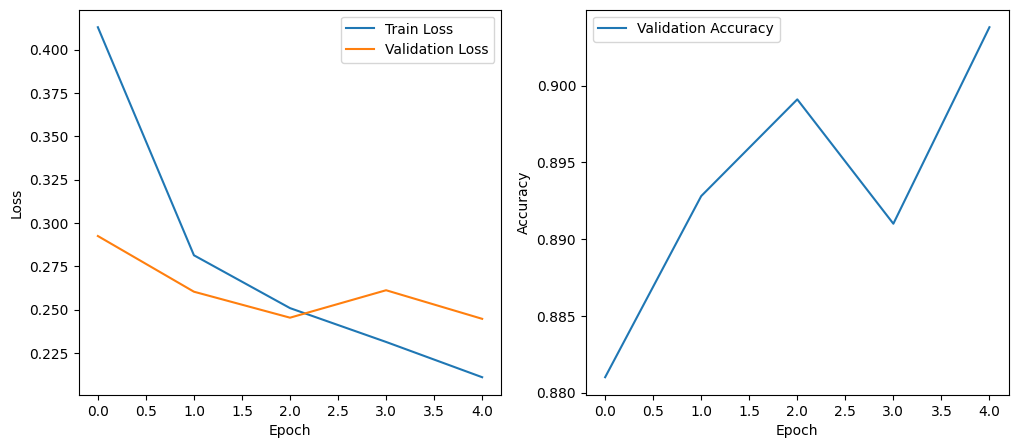

In [34]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()